In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import b3d
import sys

sys.path.append(str(b3d.get_root_path()))

In [3]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [4]:
path = b3d.get_assets_path() / 'mydata/pan_through_plantroom.npz'
ftd_og = b3d.io.FeatureTrackData.load(str(path))

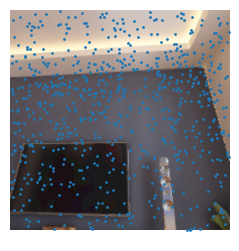

In [5]:
ftd_og.slice_time(0, 10).quick_plot(t=20, downsize=1)

In [6]:
ftd = ftd_og.strip_depth_channel()
ftd


FeatureTrackData:
    Timesteps: 76
    Num Keypoints: 1195
    Sensor shape (width x height): 200 x 200

In [7]:
def get_patch_around_region(rgb, center, size=11):
    y, x = center
    half_size = size // 2
    return rgb[y-half_size:y+half_size, x-half_size:x+half_size]

def get_patch_around_region_with_padding(rgb, center, size=11, pad_value=-1):
    center = jnp.array(center, dtype=jnp.int32)
    x, y = center
    half_size = size // 2
    padded_rgb = jnp.pad(rgb, ((half_size, half_size), (half_size, half_size), (0, 0)), mode='constant', constant_values=-1)
    return jax.lax.dynamic_slice(padded_rgb, (y, x, 0), (size, size, 3))

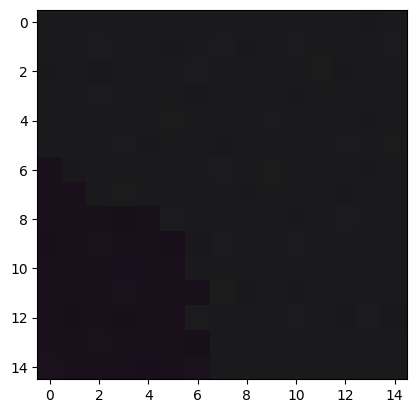

In [8]:
patch = get_patch_around_region_with_padding(
    ftd.rgb[0],
    # [int(x) for x in ftd.observed_keypoints_positions[0, 8]],
    jnp.array(ftd.observed_keypoints_positions[0, 8], dtype=jnp.int32),
    size=15
)
plt.imshow(patch)

In [9]:
def get_measure_of_spread(patch):
    """Quick measure of spread of a patch of pixels.  Patches with values below 0.2 are close to uniform."""
    patch = patch.reshape(-1, 3)
    
    # ignore positions where the rgb is -1
    num_valid = jnp.sum(patch[..., 0] != -1)
    zeroed_in_ignored = jnp.where(patch == -1, 0, patch)
    
    mean = jnp.sum(zeroed_in_ignored, axis=1) / num_valid
    diff_norms = jnp.linalg.norm(patch - mean[:, None], axis=1)
    max_norm = jnp.max(diff_norms)
    return max_norm

get_measure_of_spread(patch)

Array(0.18552679, dtype=float32)

In [10]:
def get_indices_with_large_spreads(ftd, threshold=1.0):
    spreads = jax.vmap(lambda i: get_measure_of_spread(
        get_patch_around_region_with_padding(
            ftd.rgb[0],
            jnp.array(ftd.observed_keypoints_positions[0, i], dtype=jnp.int32),
            size=11
        )
    ))(jnp.arange(0, ftd.observed_keypoints_positions.shape[1]))
    return jnp.where(spreads > threshold)[0]

ftd.slice_keypoints(get_indices_with_large_spreads(ftd))


FeatureTrackData:
    Timesteps: 76
    Num Keypoints: 729
    Sensor shape (width x height): 200 x 200

In [11]:
(
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
)


FeatureTrackData:
    Timesteps: 66
    Num Keypoints: 686
    Sensor shape (width x height): 200 x 200

In [12]:
(
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
    .slice_keypoints(get_indices_with_large_spreads(ftd, threshold=1.0))
)


FeatureTrackData:
    Timesteps: 66
    Num Keypoints: 729
    Sensor shape (width x height): 200 x 200

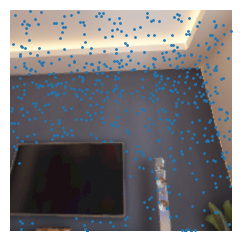

In [13]:
(
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
    .slice_keypoints(get_indices_with_large_spreads(ftd, threshold=1.0))
).quick_plot(t=0, downsize=1)

In [14]:
def get_plot(t):
    return (
        ftd
        .slice_time(10)
        .remove_points_invisible_at_frame0()
        .slice_keypoints(jnp.array([t]))
    ).quick_plot(t=0, downsize=1)

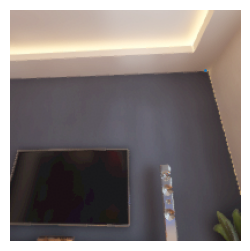

In [15]:
get_plot(213)

In [16]:
jnp.argmin(jnp.linalg.norm((
    ftd
    .slice_time(10)
    .remove_points_invisible_at_frame0()
).observed_keypoints_positions[0, :] - jnp.array([170., 50.]), axis=1))

Array(213, dtype=int32)

In [17]:
IDX = 213
onekeypoint_ftd = (
    ftd_og
    .slice_time(10)
    .remove_points_invisible_at_frame0()
    .slice_keypoints(jnp.array([IDX]))
)

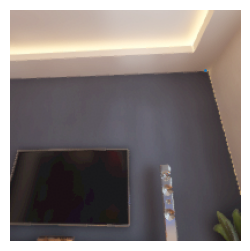

In [18]:
onekeypoint_ftd.slice_time(0, 10).quick_plot(t=0, downsize=1)

In [19]:
onekeypoint_ftd.uv[0, 0]

Array([168.50208,  51.74899], dtype=float32)

In [20]:
onekeypoint_ftd.rgb[0, 195, 5]

Array([0.24705882, 0.2509804 , 0.2784314 ], dtype=float32)

In [21]:
onekeypoint_ftd.rgb[0, 195, 195]

Array([0.30980393, 0.32156864, 0.27450982], dtype=float32)

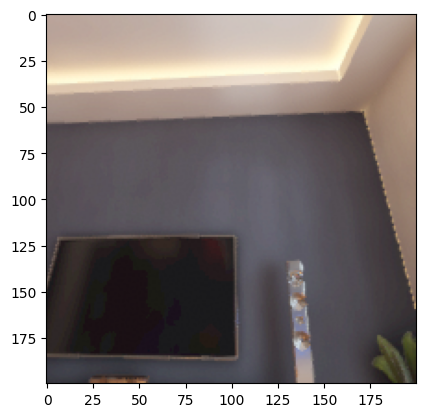

In [22]:
plt.imshow(onekeypoint_ftd.slice_time(0, 10).rgb[0])

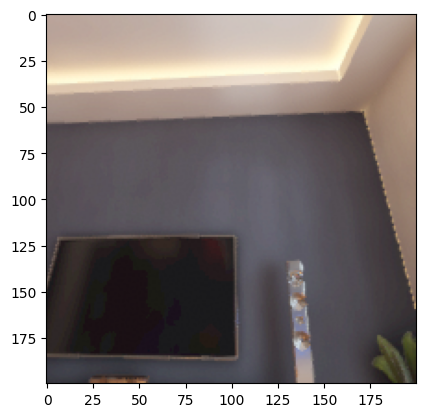

In [23]:
plt.imshow(onekeypoint_ftd.rgb[0])

In [24]:
def add_border_to_image(rgb, center, size):
    """Returns a version of `rgb` with a black square border around the center."""
    x, y = jnp.array(center, dtype=jnp.int32)
    half_size = size // 2
    # return rgb.at[y-half_size:y+half_size, x-half_size:x+half_size].set(0.)
    
    rgb = rgb.at[y-half_size:y+half_size, x-half_size].set(0.)
    rgb = rgb.at[y-half_size:y+half_size, x+half_size].set(0.)
    rgb = rgb.at[y-half_size, x-half_size:x+half_size].set(0.)
    rgb = rgb.at[y+half_size, x-half_size:x+half_size+1].set(0.)
    return rgb

In [25]:
onekeypoint_ftd.observed_keypoints_positions[0, 0]

Array([168.50208,  51.74899], dtype=float32)

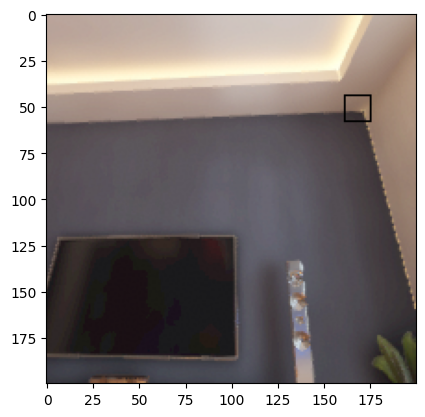

In [26]:
plt.imshow(add_border_to_image(onekeypoint_ftd.rgb[0], onekeypoint_ftd.observed_keypoints_positions[0, 0], 15))

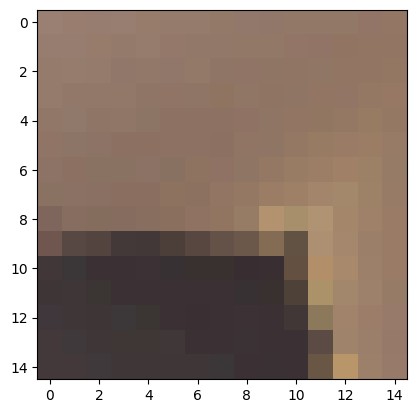

In [27]:
patch = get_patch_around_region_with_padding(
    onekeypoint_ftd.rgb[0],
    onekeypoint_ftd.observed_keypoints_positions[0, 0],
    size=15
)
plt.imshow(patch)

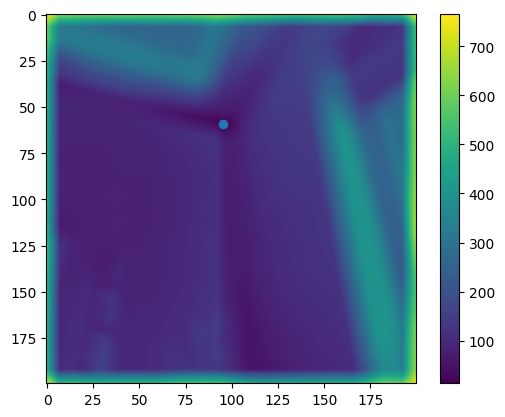

In [41]:
def patch_l1_error_at_position(rgb, center, patch):
    """Returns the L1 error between the patch and the patch centered at the given position."""
    return jnp.sum(jnp.abs(patch - get_patch_around_region_with_padding(rgb, center, size=15)))

def get_errors_across_image(rgb, patch):
    height, width, _ = rgb.shape
    return jax.vmap(jax.vmap(
        lambda x, y: patch_l1_error_at_position(rgb, (x, y), patch),
        in_axes=(0, None)
    ), in_axes=(None, 0))(
        jnp.arange(0, height), jnp.arange(0, width)
    )

def get_best_fit_pos(rgb, patch):
    errors = get_errors_across_image(rgb, patch)
    min_error = jnp.min(errors)
    y, x = jnp.where(errors == min_error, size=1)
    return x[0], y[0]

t = 20
errors_at_each_position = get_errors_across_image(onekeypoint_ftd.rgb[t], patch)
plt.imshow(errors_at_each_position)
plt.colorbar()
x, y = get_best_fit_pos(onekeypoint_ftd.rgb[t], patch)
plt.scatter([x], [y])

In [42]:
import rerun as rr
rr.init(f"conv_patch_tracking-001")
rr.connect("127.0.0.1:8812")

In [43]:
from tests.sama4d.video_to_tracks.keypoint_tracking_task import KeypointTrackingTask

task = KeypointTrackingTask(lambda: onekeypoint_ftd, n_frames=40)
task.visualize_task()

In [44]:
from tests.common.solver import Solver
class Patch2DSolver(Solver):
    def solve(self, task_specification):
        kp0 = task_specification["initial_keypoint_positions_2D"]
        assert kp0.shape == (1, 2), "Currently only single-keypoint-tracking is supported."
        kp0 = kp0[0]
        rgb = task_specification["video"][:, :, :, :3]
        patch = get_patch_around_region_with_padding(rgb[0], kp0, size=15)
        errors = get_errors_across_image(rgb[0], patch)
        bestfit_positions_x, bestfit_positions_y = jax.vmap(
            lambda img: get_best_fit_pos(img, patch)
        )(rgb)
        stacked_xy = jnp.stack([bestfit_positions_x, bestfit_positions_y], axis=-1) 
        return stacked_xy[:, None, :]

In [45]:
solver = Patch2DSolver()
solution = solver.solve(task.get_task_specification())
metrics = task.score(solution)
metrics

{'mean_distance_error': Array(2.4837837, dtype=float32),
 'n_errors_above_threshold_per_frame': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int32)}

In [47]:
task.visualize_solution(solution, metrics)